# **Feature Extraction: Help Computers to "Sense" the Images**

<font color='red' face='Times New Roman'>*NOTE: Before running this code, please create a folder named ``Figures`` in the root directory of your Google Drive.
Then, upload the 5 ``.jpg`` images to that folder.
Or you can directly save the following folder in your own Google Drive.*</font>

https://drive.google.com/drive/folders/1vmBVgxonnSXRTgkLr60dA0Rl7Sl7Da9i?usp=sharing

In [20]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive

drive.mount('/content/drive')
% pip install -U opencv-python

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Computers know numbers only. We have to quantize the characteretics we see from images into computer readable feature vectors, so that they can "sense" what inside the images. Let's start with the Color Histogram. It helps computers to
 sense the color compositions of images.

# **1. Color Histograms: (Color Feature)**
A color histogram of an image represents the distribution of the
composition of colors in the image.

To begin with, we can extract the histograms of gray images first.

In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

img_ext = ['.jpg', '.jpeg', '.png', '.tif', '.tiff', '.bmp']

In [ ]:


def patch_std(img: np.array, n_divide: int = 4) -> float:
    """ Calculate mean std on n_divide x n_divide patches

    Params:
        img:
            An image with size of H x W [x C], where channel is ignored.
        n_divide:
            Cut into n_divide parts along each dimension (H and W).
    """
    patches = [j for i in np.array_split(img, n_divide, axis=0)
               for j in np.array_split(i, n_divide, axis=1)]
    return np.mean(list(map(np.std, patches)))


def gray_histogram(img: np.array, norm: bool = True) -> np.array:
    """ Count the single-channel histogram

    Params:
        img:
            An image with size of H x W.
        norm:
            Whether normalize the sum of the histogram to 1.
    """
    hist = np.array([len(img[img == i]) for i in range(256)])
    if norm:
        return hist / np.size(img)
    return hist

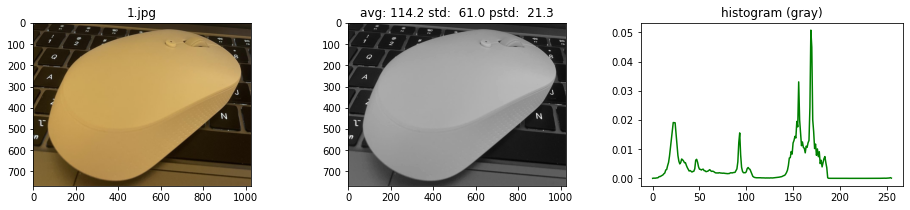

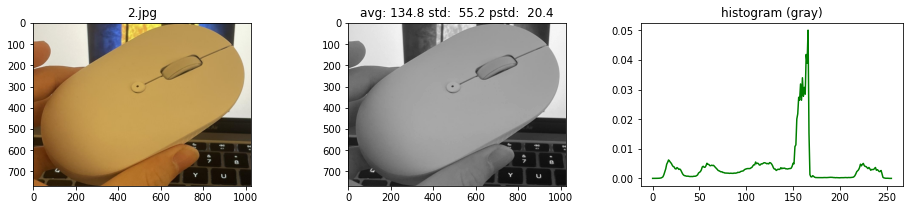

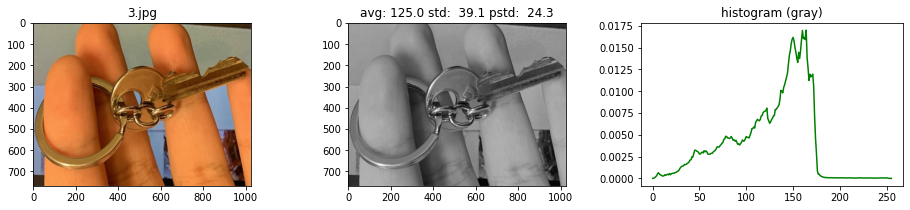

In [21]:


# configurations
src = '/content/drive/MyDrive/Figures'
img_names = ['1.jpg', '2.jpg', '3.jpg']

imgs = {}

for fname in img_names:
    plt.figure(figsize=(16, 3))
    fpath = os.path.join(src, fname)

    # Display orginal image in the first column.  [1,2,3] -> [3,2,1]
    img = cv2.imread(fpath, cv2.IMREAD_COLOR)[..., ::-1]  # BGR channels
    imgs[fname] = img
    plt.subplot(131)
    plt.title(fname)
    plt.imshow(img)

    # Display gray image in the second column
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    plt.subplot(132)
    plt.title('avg: %5.1f std: %5.1f pstd: %5.1f' % (np.mean(img_gray),
                                                     np.std(img_gray),
                                                     patch_std(img_gray, 10)))
    plt.imshow(img_gray, cmap='gray')

    # Show gray-color histogram in the third column
    plt.subplot(133)
    count_gray = gray_histogram(img_gray)
    plt.title('histogram (gray)')
    plt.plot(range(256), count_gray, c='g')

# ------------------------------------------------------------------------------
# Note:
#   1.jpg is with complex background
#   2.jpg is with foreground more distinguishable from the background
#   3.jpg is darker than the other two
# ------------------------------------------------------------------------------

Do you see the difference. The image-2 which is whiter than the other two. It has a histogram with values distributed more in the range of [150, 180] indicating that most its pixels are with values in that range. It thus make the image appreared whiter.

For that of the image-1, there are two groups of the histograms. One is in the range of [0, 100] which consists of background pixels, which the other is in the range of [150, 200] which consists of foreground.

This is how histograms help the computers to sense the brightness and constrast of images. 

# <font color='red' face='Times New Roman'>**Task 1: RGB-Color Histograms</font>**
Similarly, we can apply this to the 3 channels (i.e., RGB) of the images. That's the idea of Color Histograms.


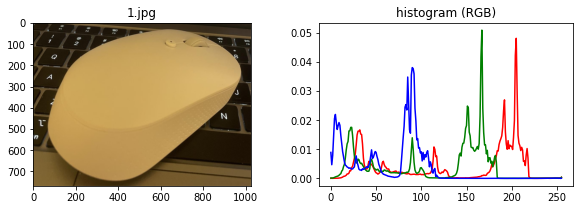

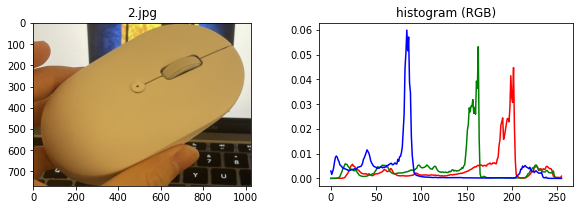

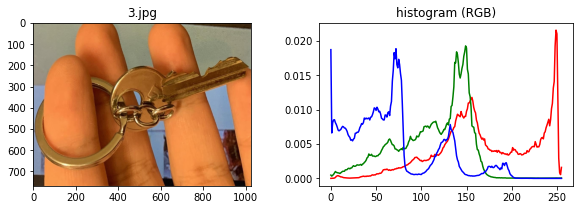

In [22]:
# draw the RGB color histograms of these images


def color_histogram(img: np.array, norm: bool = True) -> np.array:
    """ Count the multi-channel histogram
    
    Params:
        img:
            An image with size of H x W x C.
        norm:
            Whether normalize the sum of the histogram for each channel to 1.
    """
    return np.array([gray_histogram(img[..., i], norm=norm) for i in range(3)])


for k, img in imgs.items():
    plt.figure(figsize=(10, 3))

    # plot original image in the first column
    plt.subplot(121)
    plt.title(k)
    plt.imshow(img)

    # plot rgb-histogram in the second column
    plt.subplot(122)
    plt.title('histogram (RGB)')
    hists = color_histogram(img)

    ##TODO for plot 
    plt.plot(range(256), hists[0], color='r')
    plt.plot(range(256), hists[1], color='g')
    plt.plot(range(256), hists[2], color='b')


See? Now computers can sense the colors.

# **2. LBP: Local Binary Pattern: Texture Feature** 

Texture feature refers to the common internal characteristics of the object surface, which contains important information of the structure and arrangement of the object surface and its relationship with the surrounding objects.


LBP help the computer sense the textures. Let's see what it is through examples.

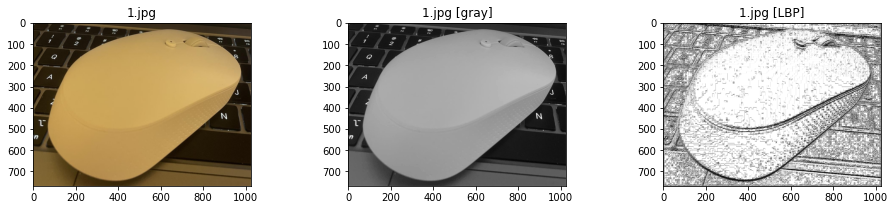

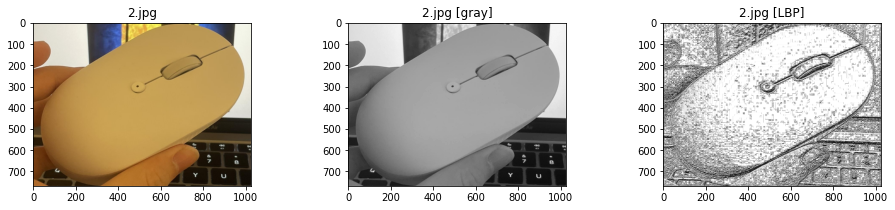

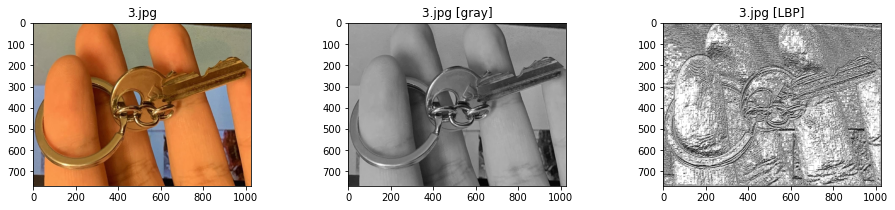

In [23]:
# draw the LBP pattern images and feature vectors

def unfold(img: np.array, ksize: int = 3) -> np.array:
    """ unfold without center point, only odd kernel size is supported
    
    Params:
        img:
            An image with size of H x W.
        ksize:
            The kernel size
    """
    assert ksize % 2 == 1
    assert img.ndim == 2
    H, W = img.shape

    # Expand the orignal image's shape for better moving. For the third channel, we pre-define its dimension as eight, 
    # the LBP result of each pixel depends on the values ​​of the surrounding 8 points 
    target = np.zeros((H + ksize - 1, W + ksize - 1, ksize ** 2 - 1), dtype=img.dtype)
    n = 0
    for h in range(ksize):
        for w in range(ksize):
            if h == ksize // 2 and w == ksize // 2:
                continue
            target[h:h + H, w:w + W, n] = img
            n += 1
    return target[ksize // 2:ksize // 2 + H, ksize // 2:ksize // 2 + W, :]


def original_LBP(img: np.array) -> np.array:
    """ calculate the original version of LBP
    
    Params:
        img:
            An image with size of H x W.
            
    Pattern:
        4 3 2
        5 / 1
        6 7 8
    """
    img_unfold = unfold(img)
    factor1 = img_unfold >= img[..., None]
    factor2 = np.array([128, 64, 32, 1, 16, 2, 4, 8], dtype=np.int32)
    return np.sum((factor1 * factor2), axis=-1)


for k, img in imgs.items():
    plt.figure(figsize=(16, 3))

    # Display orginal image in the first column
    plt.subplot(131)
    plt.title(k)
    plt.imshow(img)

    # Display gray image in the second column
    plt.subplot(132)
    plt.title(k + ' [gray]')
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    plt.imshow(img_gray, cmap='gray')

    # Display LBP feature in the third column
    plt.subplot(133)
    plt.title(k + ' [LBP]')
    LBP = original_LBP(img_gray)
    plt.imshow(LBP, cmap='gray')




# <font color='red' face='Times New Roman'>**Task 2: Circle-LBP**</font>
The above LBP operator method is very simple, but the disadvantage is also obvious, that is, the coverage area is fixed, only the surrounding 8 pixel area. To solve this limitation, you should implement the circle-LBP.


![img](https://drive.google.com/uc?id=1dzlbf3I5AoZRm4UAIFwoqddRgwEgF_tw)

\\
<font color='red'>Step 1</font>: Given the center point $(x_c,y_c)$, sampling point location can be calculated by:
$$ x_p = x_c + Rcos\frac{2𝝿\times p}{P},$$
$$ y_p = y_c - Rsin\frac{2𝝿\times p}{P},$$
where $R$ is the radius, $P$ is the number of sampling points, $p \in [1,...,P]$.

\\
<font color='red'>Step 2</font>: Note that, the calculated location $(x_p, y_p$) may not be an integer, you can use bilinear interpolation algorithm to calculate its pixel value from its surrounding four points: 

[top left point $(x_{p_0}, y_{p_0})$:  (np.floor($x_p$), np.floor($y_p$))]

[top right point $(x_{p_1}, y_{p_0})$:  (np.ceil($x_p$), np.floor($y_p$))]

[bottom left point $(x_{p_0}, y_{p_1})$:  (np.floor($x_p$), np.ceil($y_p$))]

[bottom right point $(x_{p_1}, y_{p_1})$:  (np.ceil($x_p$), np.ceil($y_p$))]

\\
<font color='red'>Step 3</font>: The final pixel value is (step 3): 
$$ f(x_p,y_p) = [x_{p_1}-x_p, x_p-x_{p_0}][\begin{matrix}
   f(x_{p_0},y_{p_0}) & f(x_{p_0},y_{p_1}) \\
   f(x_{p_1},y_{p_0}) & f(x_{p_1},y_{p_1}) \\
  \end{matrix}][\begin{matrix}
   y_{p_1}-y_p  \\
   y_p-y_{p_0}  \\
  \end{matrix}]$$

\\
<font color='red'>Step 4</font> Similar to orignal LBP, compare each pixel value of all neighbouring points to center point(larger is set to 1, smaller is set to 0), like [00010101] and then obtain the final results by Binary to decimal $[00010101]_2 = 21$  




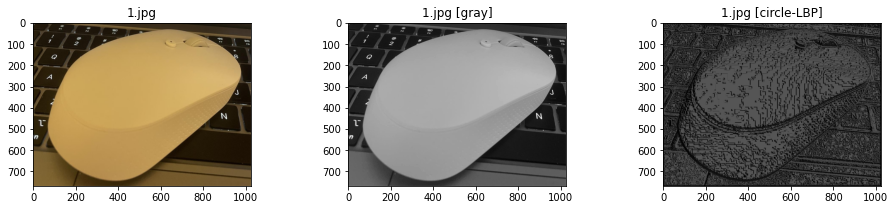

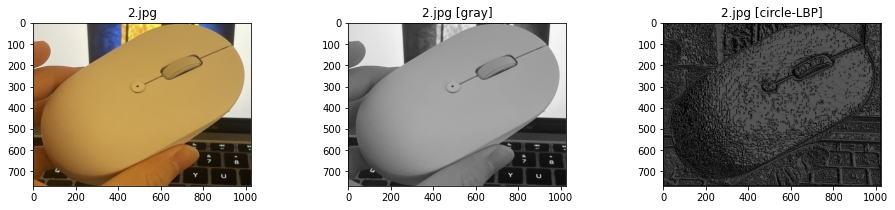

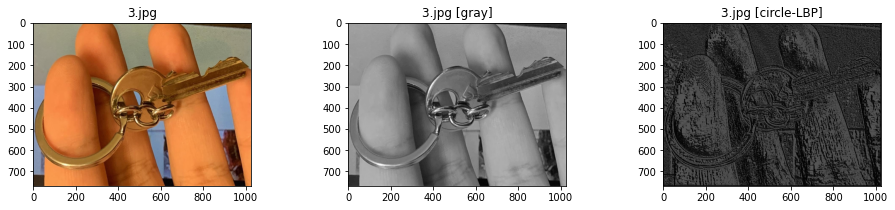

In [28]:


# TODO: implement circle_LBP
def circle_LBP(img: np.array, r: int, p: int):
    """ circle_LBP algorithm
    
    Params:
        img:
            An image with size of H x W.
        r:
            The radius of circle, e.g., 3
        p:
            The number of sampling points, e.g., 8
    """
    h, w = img.shape
    dst = np.zeros((h, w), dtype=img.dtype)

    for i in range(r, h - r):
        for j in range(r, w - r):
            LBP_str = []
            for k in range(p):

                # STEP 1:
                rx = i + r * np.cos(2 * np.pi * k / p)
                ry = j - r * np.sin(2 * np.pi * k / p)

                # STEP 2:
                x0 = int(np.floor(rx))
                x1 = int(np.ceil(rx))
                y0 = int(np.floor(ry))
                y1 = int(np.ceil(ry))

                # STEP 3:
                f00 = img[x0, y0]
                f01 = img[x0, y1]
                f10 = img[x1, y0]
                f11 = img[x1, y1]
                w1 = x1 - rx
                w2 = rx - x0
                w3 = y1 - ry
                w4 = ry - y0
                fxy = w3 * (w1 * f00 + w2 * f10) + w4 * (w1 * f01 + w2 * f11)

                # STEP 4:
                if fxy >= img[i, j]:
                    LBP_str.append(1)
                else:
                    LBP_str.append(0)
            LBP_str = ''.join(str(id) for id in LBP_str)
            dst[i, j] = int(LBP_str, 2)

    return dst


for k, img in imgs.items():
    plt.figure(figsize=(16, 3))

    # TODO: Display orginal image in the first column
    plt.subplot(131)
    plt.title(k)
    plt.imshow(img)

    # TODO: Display gray image in the second column
    plt.subplot(132)
    plt.title(k + ' [gray]')
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    plt.imshow(img_gray, cmap='gray')

    # TODO: Display circle_LBP feature with (r=3, p=8) in the third column
    plt.subplot(133)
    plt.title(k + ' [circle-LBP]')
    LBP = circle_LBP(img_gray, r=3, p=8)
    plt.imshow(LBP, cmap='gray')



# **3. Local Features: SIFT(Scale-invariant feature transform)**
Local features help computers sense the details of images. Let's try SIFT.

<font face='Times New Roman'>*The patent period of the SIFT algorithm has ended on March 6, 2020, please feel free to use it in commercial and academic scenarios!*</font>

# <font color='red' face='Times New Roman'>Challenge: Estimate affine transformation matrix and then conduct transformation, given pictures p1 and p2. You can transform from image 1 to image 2 and vice versa.</font>


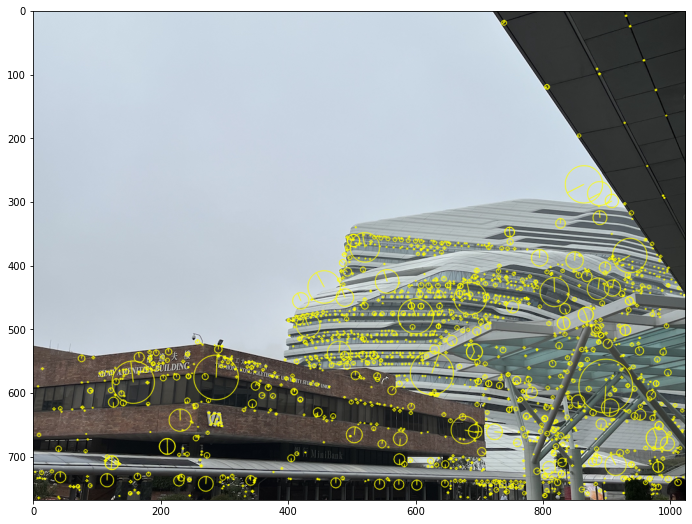

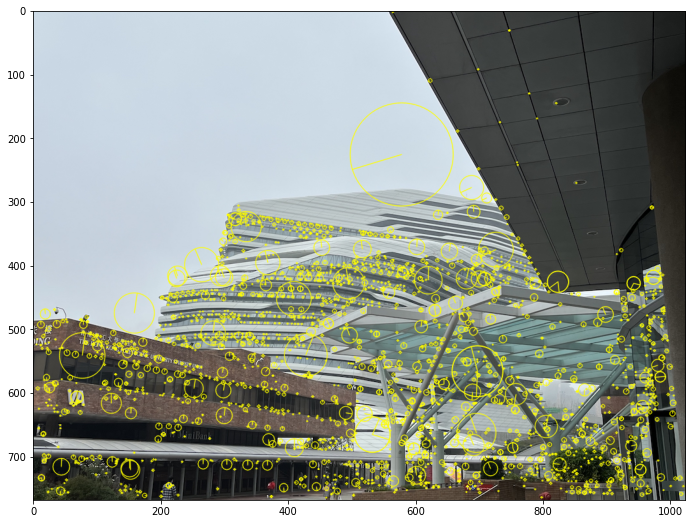

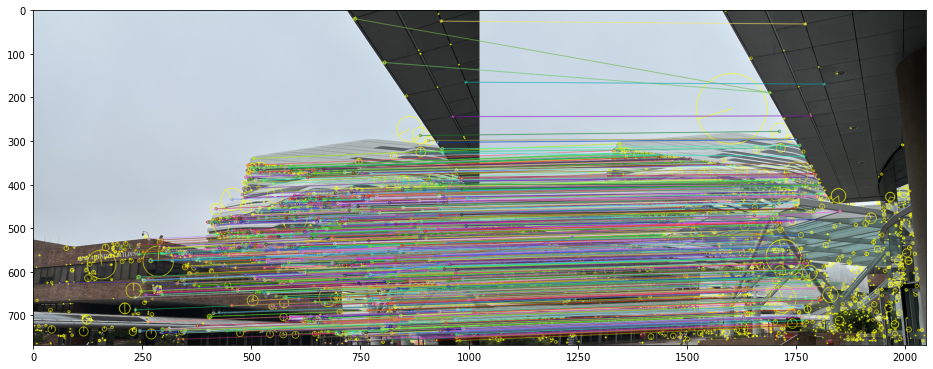

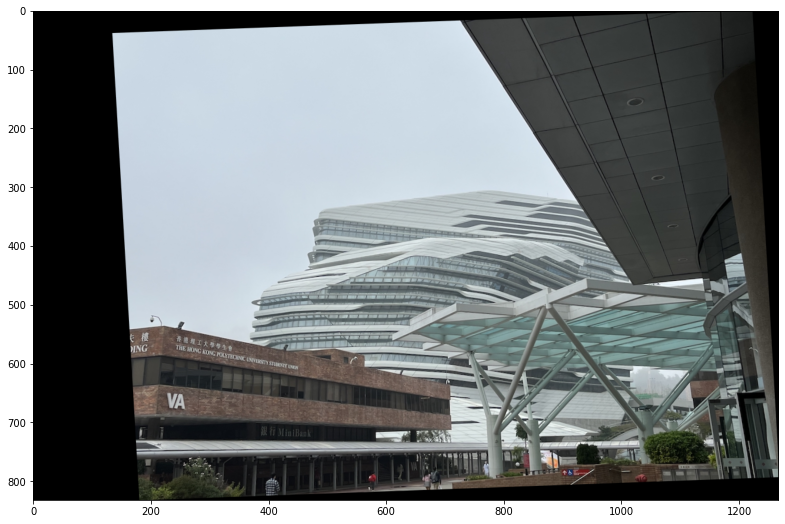

In [29]:
def dst_pos(aff, img_size, img_size2):
    '''
      Calculate the height and width of the output image
    '''
    pts = np.array([[0, 0, 1], [0, img_size[1], 1], [img_size[0], 0, 1], [*img_size, 1]])
    min_w = min_h = float('inf')
    max_w = max_h = 0
    for pt in pts:
        dst_w, dst_h = np.dot(aff, pt)
        min_w = min(min_w, dst_w)
        min_h = min(min_h, dst_h)
        max_w = max(max_w, dst_w)
        max_h = max(max_h, dst_h)
    min_w = int(min_w)
    min_h = int(min_h)
    max_w = int(max_w)
    max_h = int(max_h)
    add_w, add_h = max(-min_w, 0), max(-min_h, 0)
    min_w += add_w
    min_h += add_h
    max_w += add_w
    max_h += add_h
    return max(max_w, img_size2[0] + add_w), max(max_h, img_size2[1] + add_h), add_w, add_h


src = '/content/'
image_path1, image_path2 = os.path.join(src, 'polyu1.jpeg'), os.path.join(src, 'polyu2.jpeg')

img1 = cv2.imread(image_path1, cv2.IMREAD_COLOR)[..., ::-1]
img2 = cv2.imread(image_path2, cv2.IMREAD_COLOR)[..., ::-1]
gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

sift = cv2.SIFT_create()
# detect key points and descriptors
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)
img1_kp = img1.copy()
img2_kp = img2.copy()

# draw key points on image
'''
para:
1: orignal_image; 2: keypoints, 3: output_image , 4: color , 5: flags about how to draw key points
'''
cv2.drawKeypoints(img1, kp1, img1_kp, (255, 255, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(img2, kp2, img2_kp, (255, 255, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(16, 9))
plt.imshow(img1_kp)
plt.figure(figsize=(16, 9))
plt.imshow(img2_kp)

'''
feature matcher: FLANN (Fast_Library_for_Approximate_Nearest_Neighbors)
'''
FLANN_INDEX_KDTREE = 1  # KD tree
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=100)
flann = cv2.FlannBasedMatcher(index_params, search_params)

'''
queryDescriptors: original image
trainDescriptors: matching image
k: count of best matches found per each query descriptor
attributes of matches: 
{
  distance: the distance between two feature points;
  queryIdx：query descriptor index;
  trainIdx：train descriptor index;
}
'''
matches = flann.knnMatch(queryDescriptors=des1, trainDescriptors=des2, k=2)  # best match and second match

'''
find good match, m: best match; n: second best match
'''
goodMatch = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        goodMatch.append(m)
goodMatch_np = np.expand_dims(goodMatch, 1)

'''
draw match
cv2.drawMatchesKnn :: flag 2: single keypoints will not be drawn.
'''
img_out = cv2.drawMatchesKnn(img1_kp, kp1, img2_kp, kp2, goodMatch_np, None, flags=2)
plt.figure(figsize=(16, 9))
plt.imshow(img_out)


In [ ]:

'''
obtain pixels from original (query) and target(train) image
'''
query_points = []
train_points = []
for m in goodMatch:
    query_points.append(kp1[m.queryIdx].pt)
    train_points.append(kp2[m.trainIdx].pt)
query_points = np.array(query_points)
train_points = np.array(train_points)

'''
calculated the best affine matrix by function: 
[H, inliers] = cv2.estimateAffine2D (from, to): from First input 2D point set containing (X,Y), to Second input 2D point set containing (x,y)
H: Output 2D affine transformation matrix 2x3 ([a11 a12 b1; a21 a22 b2].) (rotation matrix and offset value)
[x; y] = [a11 a12; a21 a22] * [X; Y] + [b1; b2]
'''
#TODO
AffineMatrixImg2, _ = cv2.estimateAffine2D(train_points, query_points)

'''
apply affine transformation on image by function: 
output_img = cv2.warpAffine(original_img, affine_matrix, (width, height))
'''
#TODO
max_w, max_h, add_w, add_h = dst_pos(AffineMatrixImg2, img2.shape[1::-1], img1.shape[1::-1])
AffineMatrixImg2[:, 2] += (add_w, add_h)

img2 = cv2.warpAffine(img2, AffineMatrixImg2, (max_w, max_h))
plt.figure(figsize=(16, 9))
plt.imshow(img2)
